In [4]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from tqdm import tqdm


# Ebola Model
We want to model the possibility of a major outbreak from a single infected individual.


In [7]:
def ebola_rates(phi,lambda_c,beta,alpha,h,lambda_h):
    # h: probability an infected individual will be treated in the hospital
    # lambda_c*beta*alpha: rate at which HCW get infected (always will be treated at the hospital)
    # phi: rate of infections in a burial (average secondary infections in a burial)
    # lambda_h: rate of infected visitors
    # 
    b_cc = (phi + lambda_c)*(1-h)
    b_hh = lambda_h*h + lambda_c*beta*alpha
    b_ch = h*(phi+lambda_c)
    b_hc = lambda_h*(1-h)
    return b_cc,b_hh,b_ch,b_hc

In [18]:
def ebola_sir(N,phi=2.18,lambda_c=1.1,beta=4,alpha=0.019,h=0.6,lambda_h=0.25,mu=1):
    # B_cc: rate person infected in the community transmits to an individual that will be treated at the community
    # B_ch: infected at the community infects individual treated at the hospital
    # B_hh: infected at the hospital infects individual treated at the hospital
    # B_hc: infected at the hospital infects individual treated at the community
    # Epsilon: infectiousness of someone that alerady had inmunity
    # Mu: recovery rate assumed to be 1 as we are taking the time of infection as a measure for time
    Nh = N*h
    Nc=N-Nh
    Ic=1; Sc=Nc-1; Rc=0
    Ih=0; Sh=Nh; Rh=0
    t=0
    times=[t]
    I_community=[Ic]; S_community=[Sc]; R_community=[Rc]
    I_hospital=[Ih]; S_hospital=[Sh]; R_hospital=[Rh]

    bcc,bhh,bch,bhc = ebola_rates(phi,lambda_c,beta,alpha,h,lambda_h)
     
    while (Ic+Ih)>0:
        Sc2Ic_rate = bcc*Sc*Ic/Nc+bhc*Sc*Ih/Nc
        Ic2Rc_rate = mu * Ic
        Sh2Ih_rate = bch*Sh*Ic/Nh+bhh*Sh*Ih/Nh
        Ih2Rh_rate = mu * Ih
        sum= Sc2Ic_rate + Ic2Rc_rate + Sh2Ih_rate + Ih2Rh_rate

        r1 = np.random.uniform()
        r2 = np.random.uniform()

        t+=(-1/sum)*np.log(r1)
        times.append(t)

        if r2 <  Sc2Ic_rate/sum:
            Sc-=1
            Ic+=1
        elif r2 < (Sc2Ic_rate + Ic2Rc_rate)/sum:
            Ic-=1
            Rc+=1

        elif r2 < (Sc2Ic_rate + Ic2Rc_rate  + Sh2Ih_rate)/sum:
            Sh-=1
            Ih+=1
        else:
            Ih-=1
            Rh+=1
        S_community.append(Sc)
        S_hospital.append(Sh)
        I_community.append(Ic)
        I_hospital.append(Ih)
        R_community.append(Rc)
        R_hospital.append(Rh)

        total_infections = R_community[-1]+R_hospital[-1]
        
    return times, S_community, S_hospital, I_community, I_hospital,R_community, R_hospital, total_infections

## Values of the rates
From https://journals.plos.org/plosbiology/article/file?id=10.1371/journal.pbio.1002056&type=printable 
we obtained the values for the different rates (using table 1)

Hospitalization rate (h) 0.6

Secondary cases from a funeral (ϕ) 5.9/2.18

Core secondary transmission rate (λ_c) 1.1

Household contacts (N) 6.4

Transmission probability (q) 0.16

Hospital leakage (λh) 0.25 / 0.3

Hospital contact multiplier (β) 4

100%|███████████████████████████████████████| 1000/1000 [01:33<00:00, 10.66it/s]


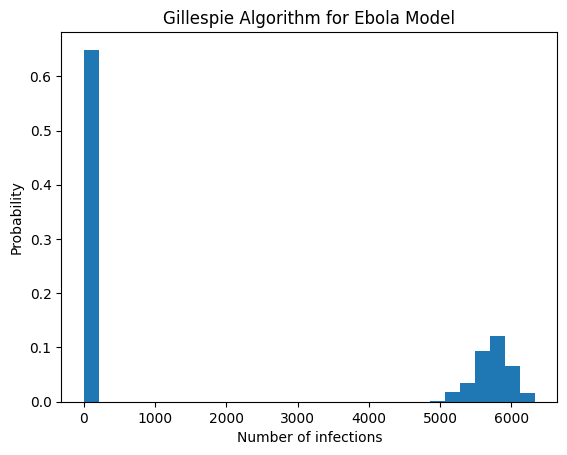

The probability using Gillespie Algorithm is 0.351


In [31]:
def simulation(n_times,N):
    n_infection=[]
    for _ in tqdm(range(n_times)):
        infections = ebola_sir(N)[-1]
        n_infection.append(infections)   
    return n_infection
n_times,N = 100_000,10_000
n_infections=simulation(n_times,N)
weight=np.ones_like(n_infections)/len(n_infections)

plt.hist(n_infections,bins=30,weights=weight)
plt.xlabel('Number of infections')
plt.ylabel('Probability')
plt.title('Gillespie Algorithm for Ebola Model')
plt.show()

print(f'The probability using Gillespie Algorithm is', np.sum(np.array(n_infections)/N>0.2)/n_times)

100%|███████████████████████████████████████| 1000/1000 [01:23<00:00, 11.97it/s]


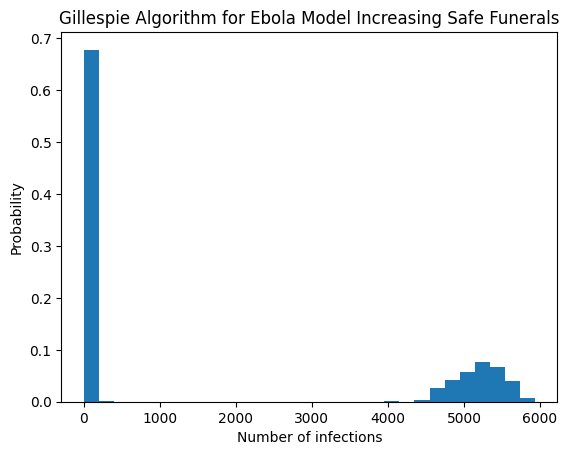

The probability using Gillespie Algorithm is 0.32


In [32]:
def simulation_funeral(n_times,N):
    n_infection=[]
    for _ in tqdm(range(n_times)):
        infections = ebola_sir(N,phi=2)[-1]
        n_infection.append(infections)   
    return n_infection
n_times,N = 1000,10_000
n_infections=simulation_funeral(n_times,N)
weight=np.ones_like(n_infections)/len(n_infections)

plt.hist(n_infections,bins=30,weights=weight)
plt.xlabel('Number of infections')
plt.ylabel('Probability')
plt.title('Gillespie Algorithm for Ebola Model Increasing Safe Funerals')
plt.show()

print(f'The probability using Gillespie Algorithm is', np.sum(np.array(n_infections)/N>0.2)/n_times)